<a href="https://www.kaggle.com/nettasav/hr-analytics-86-accuracy?scriptVersionId=84795909" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


# Overview
This notebook is organized as follows :

1. Reading the data
2. EDA - Exploratory data analysis
3. Data preproccesing and cleaning
4. Training models
5. Results

# 1. Reading the data

In [2]:
train = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
test = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_test.csv')

# 2. EDA - Exploratory data analysis

Explore the data.

First I visualized the relationships between each variable to the other variables in the data using Pairplot. Then I used methods like head(), describe(), info() ect. to display the first five rows of each data set, display basic statistical details and general information about the data.

Afterwards I visualized the missing data using the missingno library in order to decide which colunmns to drop and how to deal with the missing values, together with the pairplot and other visualizations shown below.

## Train set

In [3]:
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [4]:
train.shape

(19158, 14)

In [5]:
train.columns

Index(['enrollee_id', 'city', 'city_development_index', 'gender',
       'relevent_experience', 'enrolled_university', 'education_level',
       'major_discipline', 'experience', 'company_size', 'company_type',
       'last_new_job', 'training_hours', 'target'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

As shown above, this data set contains 14 columns. i.e 13 features + 1 label.

10 categorical variables: `city`, `gender`, `relevent_experience`, `enrolled_university`, `education_level`, `major_discipline`, `experience`, `company_size`,`last_new_job`,`company_type`

3 numerical variables: `enrollee_id`, `city_development_index`,`training_hours`

1 label variable - `target`


      
       

In [7]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


### Visualizing the data

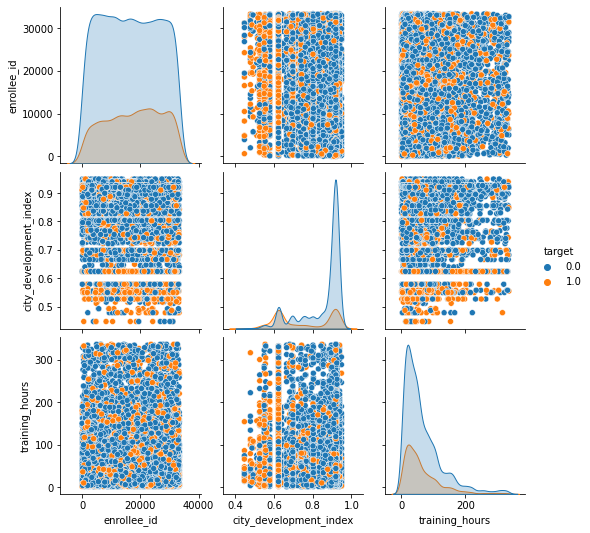

In [8]:
import seaborn as sns

sns.pairplot(train, hue='target')

In [9]:
train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

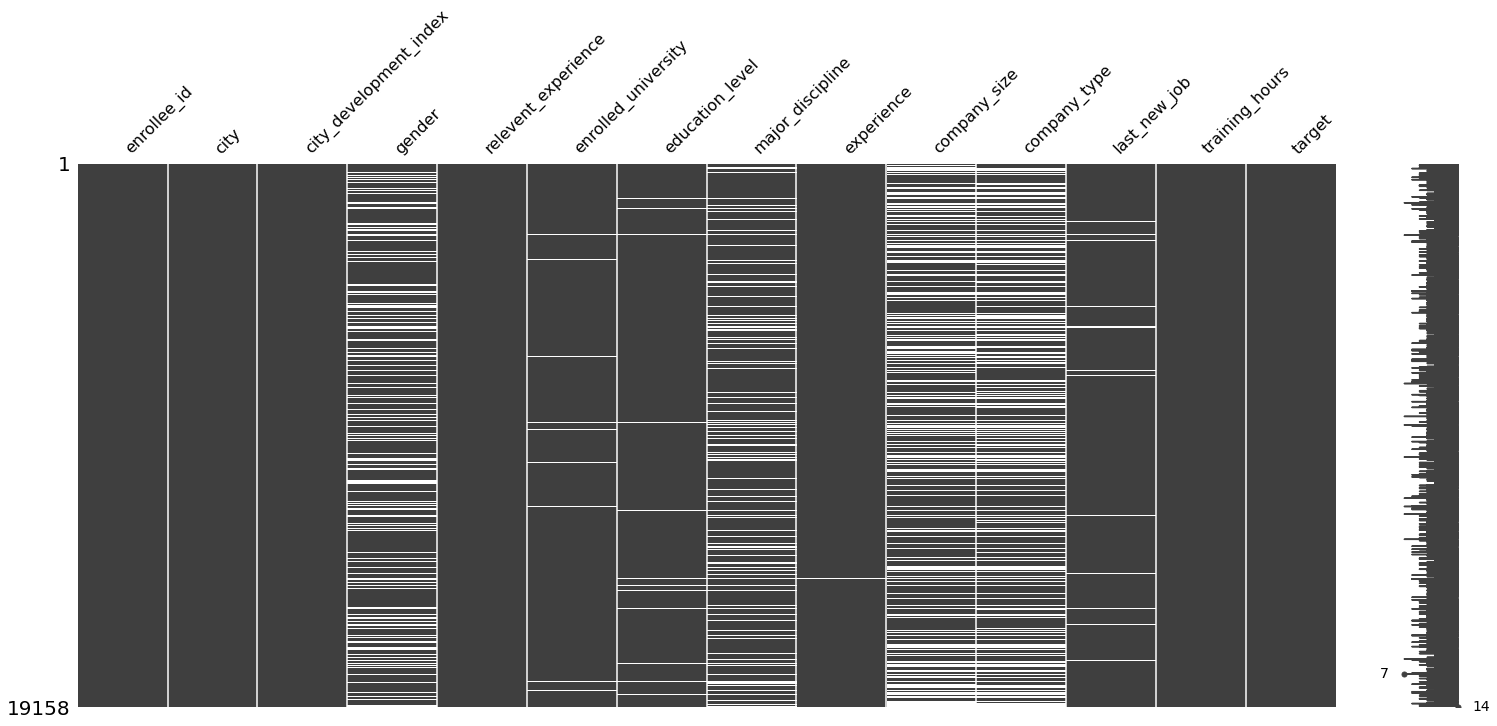

In [10]:
# Visualize missing data 

import missingno as msno
import matplotlib.pyplot as plt
msno.matrix(train)
plt.show()

White lines indicate missing values, while black lines represent existing information.

As one can see, the `gender`, `major_discipline`, `company_size` and `company_type` columns have many missing value, scattered throughout the columns, and the `enrolled_university`, `education_level`,`experience` and `last_new_job`  column has only few missing values.

<AxesSubplot:>

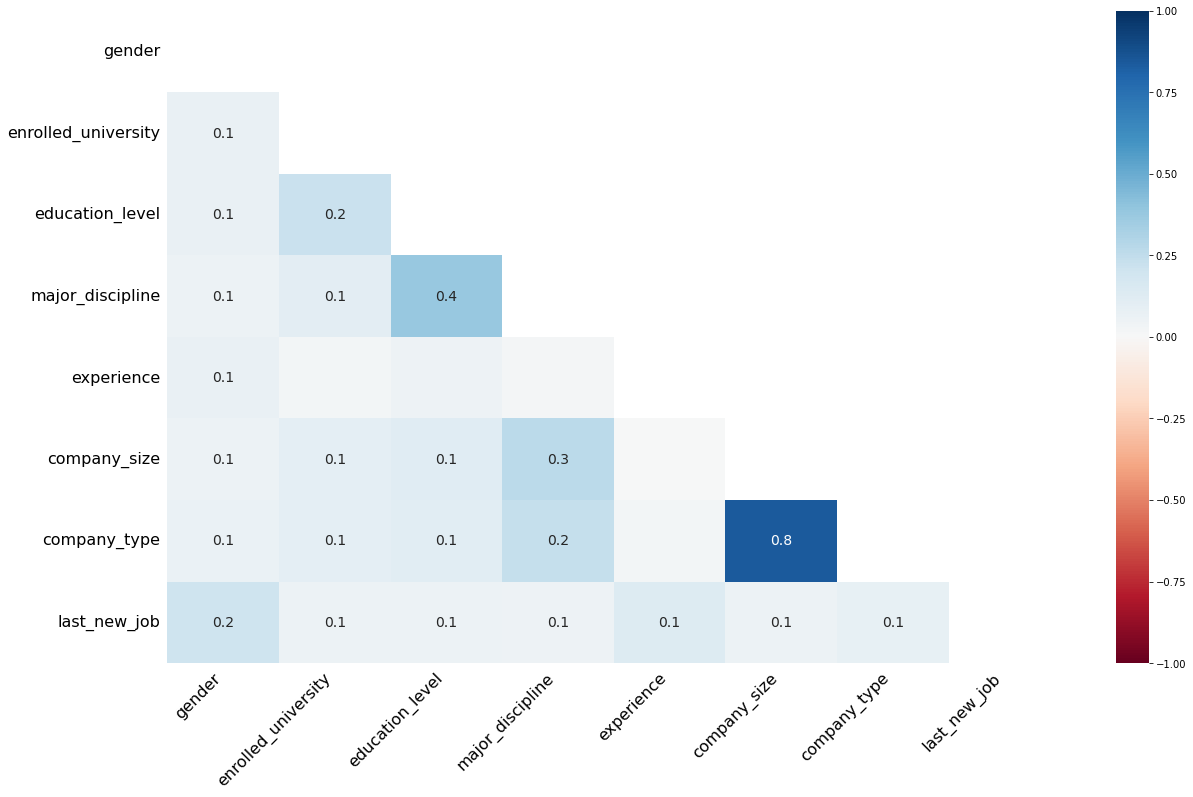

In [11]:
msno.heatmap(train)

The missingno correlation heatmap measures nullity correlation, i.e how strongly the presence or absence of one variable affects the presence of another ([link for more information](https://github.com/ResidentMario/missingno))

In this example, it seems that if the variable `company_size` appears, than the variable `company_type` is also likely to appear (correlation = 0.8)

## Test set

In [12]:
test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [13]:
test.shape

(2129, 13)

In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


In [15]:
test.isnull().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

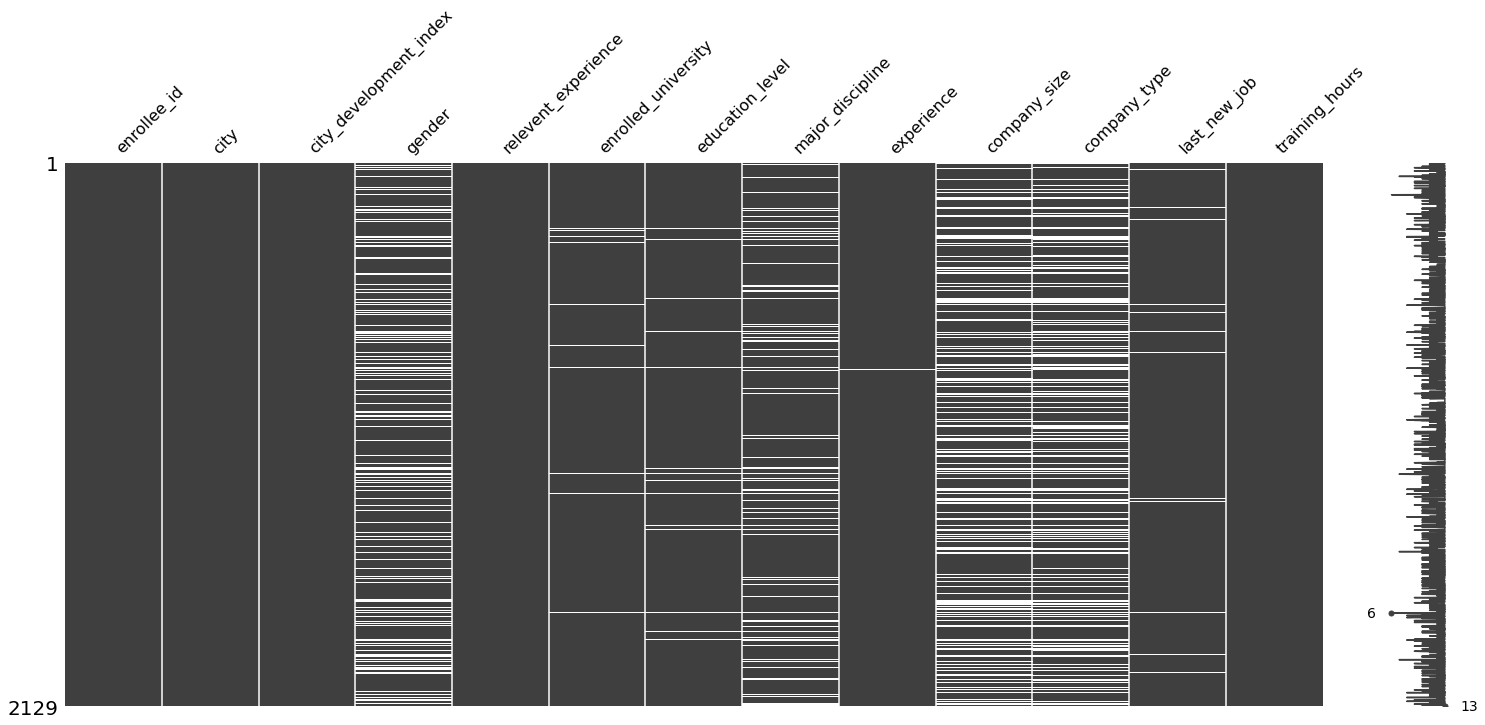

In [16]:
# Visualize missing data in the test data

msno.matrix(test)
plt.show()

The same conclusions for the test set - most of the `gender`,`company_size` and `comapny_type` columns are missing, as well as few values in the `enrolled_university`,`education_level`, `experience` and`last_new_job` columns.

# 3. Data preproccesing and cleaning

Create a new dataframe for the rest of the processing, keeping the `enrollee_id` column in the full dataframe for the final stage of writing to the csv file.



In [17]:
train_df = train.drop(['enrollee_id'], axis=1)
test_df = test.drop(['enrollee_id'], axis=1)

## Dealing with missing values and cleaning the data


These data contains ordinal and nominal columns. i.e in some columns the order of the categiries is significnt (ordinal) and in others there is no meaning to the order or the quantity of the value (nominal). 

The ordinal columns in our data are : `relevent_experience`, `enrolled_university`, `education_level`, `experience`, `company_size`,`last_new_job`,

The nominal columns are: `city`, `gender`,  `major_discipline`, `company_type`.

####  Label Encoding
Most machine learning models require the categorical variables to be in one-hot encoding representation, or to be mapped into numbers.

we will apply ordinal encoding to the ordinal columns (i.e mapping) and one-hot encoding to the nominal columns.


In [18]:
def calc_num_categories(column_name):
    unique_values_train = train[column_name].unique()
    number_of_categories_train = len(unique_values_train)

    unique_values_test = test[column_name].unique()
    number_of_categories_test = len(unique_values_test)

    if number_of_categories_train != number_of_categories_test:
        print(f'Unique values train: {unique_values_train}, \n Number of categories: {number_of_categories_train} \n Unique values test: {unique_values_test}, \n Number of categories: {number_of_categories_test}')
    else:
        print(f'Unique values: {unique_values_train}, \n Number of categories: {number_of_categories_train}')


In [19]:
def calc_percent_missing_values(train_df, test_df, column_name):  
    train_missing = train_df[column_name].isnull().sum()
    test_missing = test_df[column_name].isnull().sum()
    perc_train = (train_missing/len(train_df[column_name]))
    perc_test = (test_missing/len(test_df[column_name]))
    
    print(f'{column_name}:\n % of missing values in the train data: {train_missing} \n % of missing values in the test data: {test_missing}\
    \n %train" {perc_train:.2%} \n %test: {perc_test:.2%}')

### 1. `experience` 


In [20]:
calc_num_categories('experience')

Unique values: ['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan], 
 Number of categories: 23


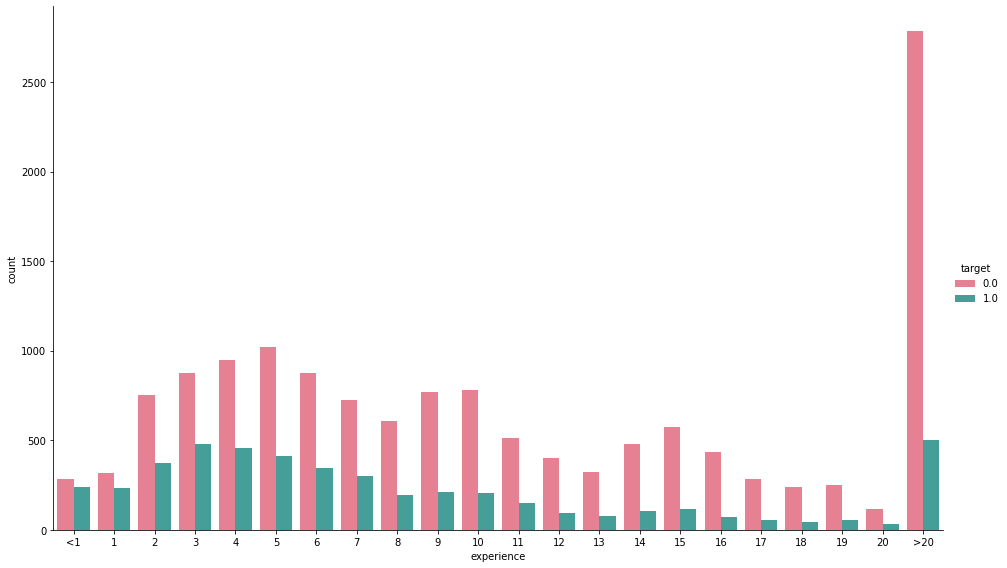

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.catplot(x="experience", kind="count", data=train, height=8, aspect=10/6, palette="husl",hue='target',
                order= ['<1', '1','2','3','4', '5','6','7','8','9','10', '11','12','13','14','15','16','17','18','19','20','>20'])

In [22]:
calc_percent_missing_values(train, test, 'experience')

experience:
 % of missing values in the train data: 65 
 % of missing values in the test data: 5    
 %train" 0.34% 
 %test: 0.23%


Since the 'experience' column is a categorical variable and there are only few missing values in this column, an appropriate choice would be to replace the missing values by the most frequent value of that column.

In [23]:
train_df["experience"] = train_df["experience"].transform(lambda x: x.fillna(x.mode()[0]))
test_df["experience"] = test_df["experience"].transform(lambda x: x.fillna(x.mode()[0]))

In [24]:
calc_percent_missing_values(train_df, test_df, 'experience')

experience:
 % of missing values in the train data: 0 
 % of missing values in the test data: 0    
 %train" 0.00% 
 %test: 0.00%


In [25]:
train_df['experience'].replace({'<1': '0', '>20': '21'}, inplace=True)
test_df['experience'].replace({'<1': '0', '>20': '21'}, inplace=True)

In [26]:
train_df['experience'].unique()

array(['21', '15', '5', '0', '11', '13', '7', '17', '2', '16', '1', '4',
       '10', '14', '18', '19', '12', '3', '6', '9', '8', '20'],
      dtype=object)

In [27]:
train_df['experience'] = train_df['experience'].astype(int)
test_df['experience'] = test_df['experience'].astype(int)

In [28]:
experience_bin_labels = [1, 2, 3,4]
train_df['Binned_experience'] =   pd.qcut(train_df['experience'], q=4, labels=experience_bin_labels).astype(int)
test_df['Binned_experience'] =    pd.qcut(test_df['experience'], q=4, labels=experience_bin_labels).astype(int)

<AxesSubplot:xlabel='Binned_experience', ylabel='count'>

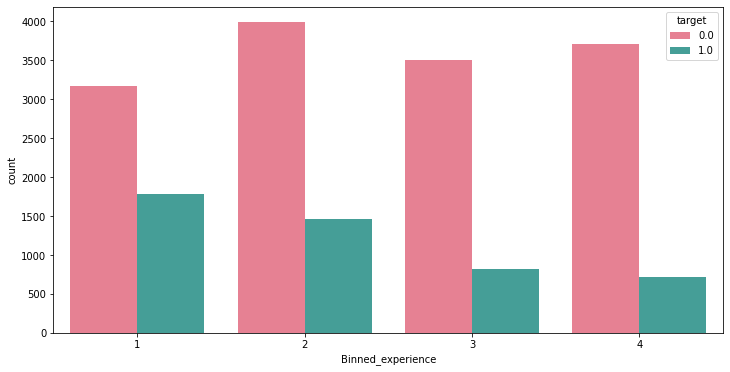

In [29]:
#sns.set(rc = {'figure.figsize':(12,6)})
plt.figure(figsize = (12,6))
sns.countplot(x="Binned_experience", hue="target", data=train_df, palette="husl")

### 2.`last_new_job`

In [30]:
calc_num_categories('last_new_job')

Unique values: ['1' '>4' 'never' '4' '3' '2' nan], 
 Number of categories: 7


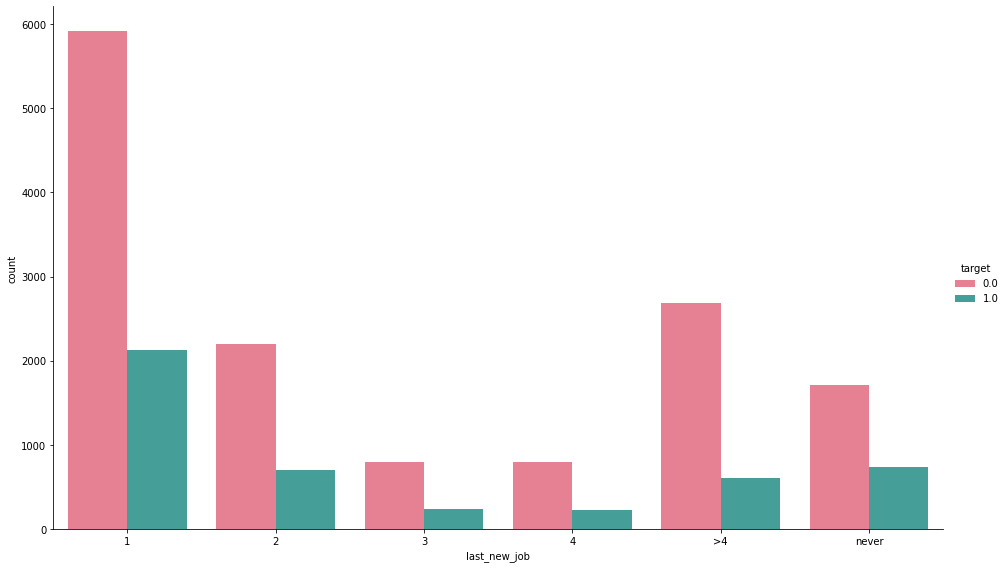

In [31]:
g = sns.catplot(x="last_new_job", kind="count", data=train, height=8, palette="husl",hue='target', order= ['1','2','3','4','>4', 'never'],aspect=10/6)

In [32]:
calc_percent_missing_values(train, test, 'last_new_job')

last_new_job:
 % of missing values in the train data: 423 
 % of missing values in the test data: 40    
 %train" 2.21% 
 %test: 1.88%


Similarly, since the 'last_new_job' column is a categorical variable and there are only few missing values in this column, an appropriate choice would be to replace the missing values by the most frequent value of that column.


In [33]:
train_df["last_new_job"] = train_df["last_new_job"].transform(lambda x: x.fillna(x.mode()[0]))
test_df["last_new_job"] = test_df["last_new_job"].transform(lambda x: x.fillna(x.mode()[0]))

In [34]:
calc_percent_missing_values(train_df, test_df, 'last_new_job')

last_new_job:
 % of missing values in the train data: 0 
 % of missing values in the test data: 0    
 %train" 0.00% 
 %test: 0.00%


In [35]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['last_new_job'] = le.fit_transform(train_df['last_new_job'])
print(le.classes_)
test_df['last_new_job'] = le.fit_transform(test_df['last_new_job'])

['1' '2' '3' '4' '>4' 'never']


### 3. `enrolled_university`

In [36]:
calc_num_categories('enrolled_university')

Unique values: ['no_enrollment' 'Full time course' nan 'Part time course'], 
 Number of categories: 4


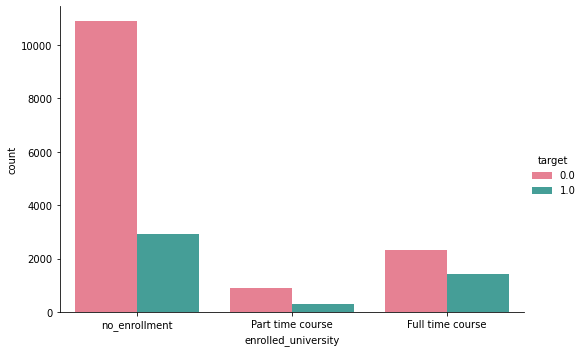

In [37]:
g = sns.catplot(x="enrolled_university", kind="count", data=train, height=5, aspect=1.5, palette="husl",hue='target',order= ['no_enrollment','Part time course','Full time course'])

In [38]:
calc_percent_missing_values(train_df, test_df, 'enrolled_university')

enrolled_university:
 % of missing values in the train data: 386 
 % of missing values in the test data: 31    
 %train" 2.01% 
 %test: 1.46%


Similarly, we replace the missing values by the most frequent value of that column.


In [39]:
train_df["enrolled_university"] = train_df["enrolled_university"].transform(lambda x: x.fillna(x.mode()[0]))
test_df["enrolled_university"] = test_df["enrolled_university"].transform(lambda x: x.fillna(x.mode()[0]))

In [40]:
calc_percent_missing_values(train_df, test_df, 'enrolled_university')

enrolled_university:
 % of missing values in the train data: 0 
 % of missing values in the test data: 0    
 %train" 0.00% 
 %test: 0.00%


In [41]:
enrolled_university_mapping = {'Full time course': 2, 'Part time course': 1, 'no_enrollment': 0}

train_df['enrolled_university'] = train_df['enrolled_university'].map(enrolled_university_mapping)
test_df['enrolled_university'] = test_df['enrolled_university'].map(enrolled_university_mapping)   


In [42]:
train_df['enrolled_university'].unique()

array([0, 2, 1])

### 4. `education_level` 


In [43]:
calc_num_categories('education_level')

Unique values: ['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School'], 
 Number of categories: 6


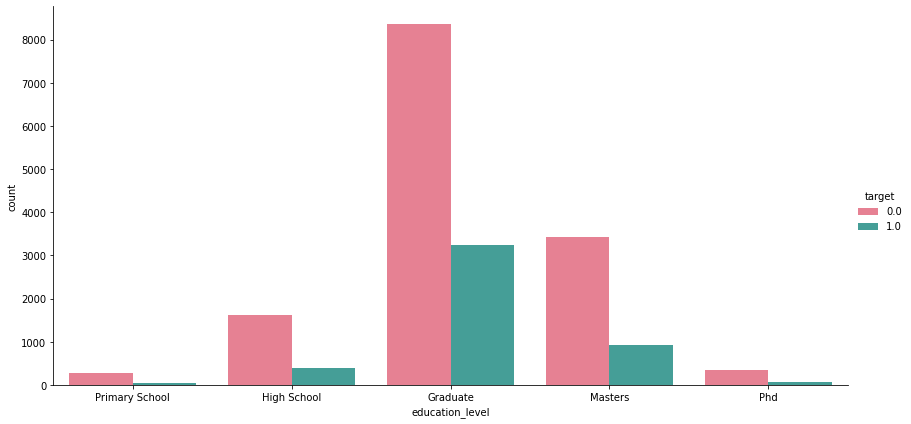

In [44]:
g = sns.catplot(x="education_level", kind="count", data=train_df, height=6, aspect=2, palette="husl",hue='target',order= ['Primary School','High School','Graduate','Masters','Phd'])

In [45]:
calc_percent_missing_values(train_df, test_df, 'education_level')

education_level:
 % of missing values in the train data: 460 
 % of missing values in the test data: 52    
 %train" 2.40% 
 %test: 2.44%


Similarly, we replace the missing values by the most frequent value of that column.

In [46]:
train_df["education_level"] = train_df["education_level"].transform(lambda x: x.fillna(x.mode()[0]))
test_df["education_level"] = test_df["education_level"].transform(lambda x: x.fillna(x.mode()[0]))

In [47]:
calc_percent_missing_values(train_df, test_df, 'education_level')

education_level:
 % of missing values in the train data: 0 
 % of missing values in the test data: 0    
 %train" 0.00% 
 %test: 0.00%


In [48]:
education_level_mapping = {'Primary School': 1,'High School': 2,'Graduate': 3,'Masters': 4,'Phd': 5}

train_df['education_level'] = train_df['education_level'].map(education_level_mapping)
test_df['education_level'] = test_df['education_level'].map(education_level_mapping)   

In [49]:
train_df.isnull().sum()

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline          2813
experience                   0
company_size              5938
company_type              6140
last_new_job                 0
training_hours               0
target                       0
Binned_experience            0
dtype: int64

### 5. `city`

In [50]:
calc_num_categories('city')

Unique values train: ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77' 'city_81' 'city_131'

#### removing unnecessary text

In [51]:
train_df['city'] = train_df['city'].str.replace('city_','')
test_df['city'] = test_df['city'].str.replace('city_','')

In [52]:
train_df.city.isnull().values.any()

False

In [53]:
le = LabelEncoder()
train_df['city'] = le.fit_transform(train_df['city'])
test_df['city'] = le.fit_transform(test_df['city'])

### 6. `relevent_experience`

In [54]:
calc_num_categories('relevent_experience')

Unique values: ['Has relevent experience' 'No relevent experience'], 
 Number of categories: 2


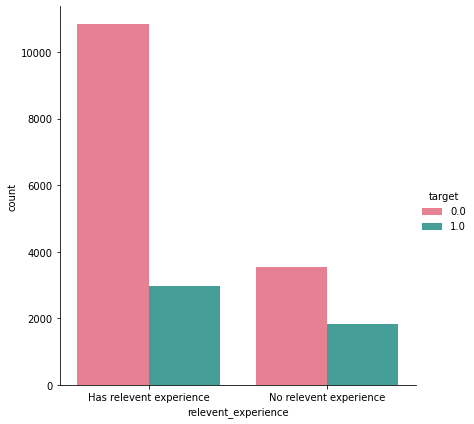

In [55]:
g = sns.catplot(x="relevent_experience", kind="count", data=train_df, height=6, aspect=1, palette="husl",hue='target')

In [56]:
relevent_experience_mapping = {'Has relevent experience': 1, 'No relevent experience': 0}

train_df['relevent_experience'] = train_df['relevent_experience'].map(relevent_experience_mapping)
test_df['relevent_experience'] = test_df['relevent_experience'].map(relevent_experience_mapping)   

In [57]:
train_df.relevent_experience.unique()

array([1, 0])

### 7. `gender` 

In [58]:
calc_num_categories('gender')

Unique values: ['Male' nan 'Female' 'Other'], 
 Number of categories: 4


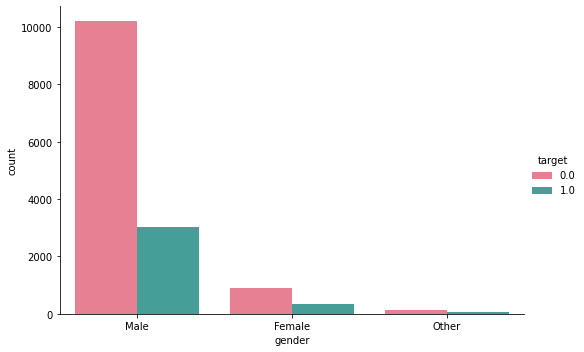

In [59]:
g = sns.catplot(x="gender", kind="count", data=train_df, height=5, aspect=1.5, palette="husl",hue='target',order= ['Male','Female','Other'])

In [60]:
train_df.gender.unique()

array(['Male', nan, 'Female', 'Other'], dtype=object)

In [61]:
train_df['gender'] = train_df['gender'].fillna('Unknown')
test_df['gender'] = test_df['gender'].fillna('Unknown')
print(train_df.gender.unique())

['Male' 'Unknown' 'Female' 'Other']


In [62]:

from sklearn.preprocessing import LabelEncoder

train_df['gender']=train_df['gender'].fillna('Unknown')
test_df['gender'] = test_df['gender'].fillna('Unknown')
print(train_df.gender.unique())

gender_mapping = {'Male': 1,'Female': 2,'Other': 3, 'Unknown': 0}

train_df['gender'] = train_df['gender'].map(gender_mapping)
test_df['gender'] = test_df['gender'].map(gender_mapping)   

['Male' 'Unknown' 'Female' 'Other']


### 8. `major_discipline`

In [63]:
calc_num_categories('major_discipline')

Unique values: ['STEM' 'Business Degree' nan 'Arts' 'Humanities' 'No Major' 'Other'], 
 Number of categories: 7


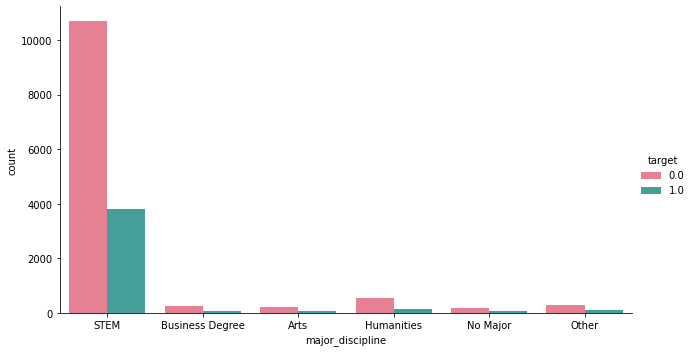

In [64]:
g = sns.catplot(x="major_discipline", kind="count", data=train_df, height=5, aspect=1.8, palette="husl",hue='target')

In [65]:
calc_percent_missing_values(train_df, test_df, 'major_discipline')

major_discipline:
 % of missing values in the train data: 2813 
 % of missing values in the test data: 312    
 %train" 14.68% 
 %test: 14.65%


In [66]:
train_df['major_discipline']=train_df['major_discipline'].fillna('Unknown')
test_df['major_discipline'] = test_df['major_discipline'].fillna('Unknown')

In [67]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() 
train_df['major_discipline'] = le.fit_transform(train_df['major_discipline'])
print(le.classes_)
test_df['major_discipline'] = le.fit_transform(test_df['major_discipline'])

['Arts' 'Business Degree' 'Humanities' 'No Major' 'Other' 'STEM' 'Unknown']


### 9. `company_size` 

In [68]:
calc_num_categories('company_size')

Unique values: [nan '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500'
 '500-999'], 
 Number of categories: 9


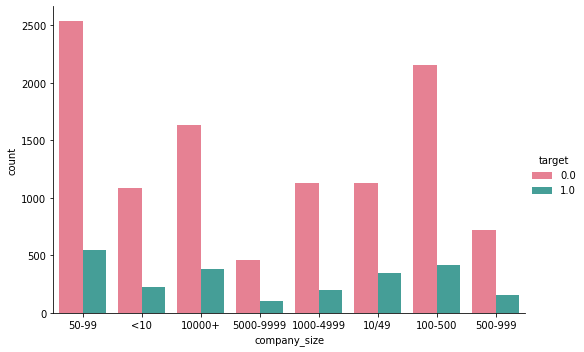

In [69]:
g = sns.catplot(x="company_size", kind="count", data=train_df, height=5, aspect=1.5, palette="husl",hue='target')

In [70]:
calc_percent_missing_values(train_df, test_df, 'company_size')

company_size:
 % of missing values in the train data: 5938 
 % of missing values in the test data: 622    
 %train" 30.99% 
 %test: 29.22%


In [71]:
train_df['company_size']=train_df['company_size'].fillna('Unknown')
test_df['company_size'] = test_df['company_size'].fillna('Unknown')
print(train_df.company_size.unique())

['Unknown' '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49'
 '100-500' '500-999']


In [72]:
company_size_mapping = {'<10': 1,'10/49': 2,'50-99': 3, '100-500': 4,'500-999': 5,'1000-4999': 6,'5000-9999': 7,'10000+': 8, 'Unknown': 0}

train_df['company_size'] = train_df['company_size'].map(company_size_mapping)
test_df['company_size'] = test_df['company_size'].map(company_size_mapping)   
print(train_df.company_size.unique())

[0 3 1 8 7 6 2 4 5]


### 10. `company_type` 

In [73]:
calc_num_categories('company_type')

Unique values: [nan 'Pvt Ltd' 'Funded Startup' 'Early Stage Startup' 'Other'
 'Public Sector' 'NGO'], 
 Number of categories: 7


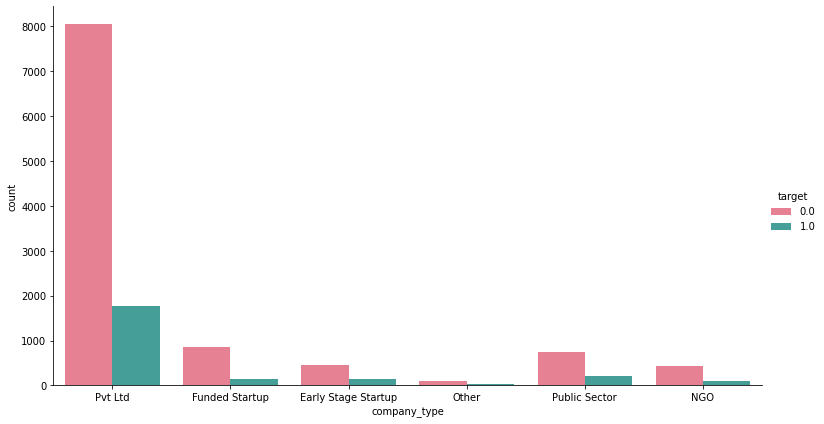

In [74]:
g = sns.catplot(x="company_type", kind="count", data=train_df, height=6, aspect=1.8, palette="husl",hue='target')

In [75]:
calc_percent_missing_values(train_df, test_df, 'company_type')

company_type:
 % of missing values in the train data: 6140 
 % of missing values in the test data: 634    
 %train" 32.05% 
 %test: 29.78%


In [76]:
train_df['company_type']=train_df['company_type'].fillna('Unknown')
test_df['company_type'] = test_df['company_type'].fillna('Unknown')

In [77]:
le = LabelEncoder()
train_df['company_type'] = le.fit_transform(train_df['company_type'])
print(le.classes_)
test_df['company_type'] = le.fit_transform(test_df['company_type'])

['Early Stage Startup' 'Funded Startup' 'NGO' 'Other' 'Public Sector'
 'Pvt Ltd' 'Unknown']


## Fill missing values using RandomForestClassifier

In [78]:
train_df.columns


Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target', 'Binned_experience'],
      dtype='object')

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#'city', 'city_development_index', 'relevent_experience', 'enrolled_university', 'education_level','major_discipline', 'experience', 'company_size',\
#'company_type','last_new_job', 'training_hours'

# split the dataset into train and test sets
train_gender = train_df.loc[train_df.gender != 0][['gender','city','experience','city_development_index','major_discipline',\
                                                   'company_size','last_new_job']]
print(train_gender.isnull().sum())
test_gender = train_df.loc[train_df.gender == 0][['gender', 'city', 'experience','city_development_index','major_discipline',\
                                                   'company_size','last_new_job']]


X_train = train_gender.drop('gender', axis=1)
y_train = train_gender.gender
X_test = test_gender.drop('gender', axis=1)
print(X_train.shape)
print(X_test.shape)

#knn = KNeighborsClassifier(n_neighbors=12, p=1)
#knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)

rf = RandomForestClassifier(n_estimators=2500, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

train_df.loc[train_df.gender == 0,'gender'] = y_pred

gender                    0
city                      0
experience                0
city_development_index    0
major_discipline          0
company_size              0
last_new_job              0
dtype: int64
(14650, 6)
(4508, 6)


PAY ATTENTION to train the model using the train set only. The test set is used for prediction.

In [80]:
#test set 

test_set_gender = test_df.loc[test_df.gender != 0][['gender','city','experience','city_development_index','major_discipline',\
                                                   'company_size','last_new_job']]
test_set_gender.isnull().sum()
predict_gender = test_df.loc[test_df.gender == 0][['gender','city','experience','city_development_index','major_discipline',\
                                                   'company_size','last_new_job']]


X_test_set = test_set_gender.drop('gender', axis=1)
X_test_set_predict_gender = predict_gender.drop('gender', axis=1)

y_test_pred = rf.predict(X_test_set_predict_gender)
#y_test_pred = knn.predict(X_test_set_predict_gender)

test_df.loc[test_df.gender == 0, 'gender'] = y_test_pred

In [81]:
# split the dataset into train and test sets
train_major_discipline = train_df.loc[train_df.major_discipline != 6][['relevent_experience', 'enrolled_university','major_discipline','training_hours', 'experience',\
                                                   'company_size','company_type','training_hours']]
print(train_major_discipline.isnull().sum())
test_major_discipline = train_df.loc[train_df.major_discipline == 6][['relevent_experience', 'enrolled_university','major_discipline','training_hours', 'experience',\
                                                   'company_size','company_type','training_hours']]


X_train = train_major_discipline.drop('major_discipline', axis=1)
y_train = train_major_discipline.major_discipline
X_test = test_major_discipline.drop('major_discipline', axis=1)
print(X_train.shape)
print(X_test.shape)

#knn = KNeighborsClassifier(n_neighbors=8, p=1)
#knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)

rf = RandomForestClassifier(n_estimators=2500, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

train_df.loc[train_df.major_discipline == 6,'major_discipline'] = y_pred

relevent_experience    0
enrolled_university    0
major_discipline       0
training_hours         0
experience             0
company_size           0
company_type           0
training_hours         0
dtype: int64
(16345, 7)
(2813, 7)


In [82]:
#test set 

test_set_major_discipline = test_df.loc[test_df.major_discipline != 6][['relevent_experience', 'enrolled_university', 'major_discipline','training_hours',\
                                                    'experience','company_size','company_type', 'training_hours']]
test_set_major_discipline.isnull().sum()
predict_major_discipline = test_df.loc[test_df.major_discipline == 6][['relevent_experience', 'enrolled_university','major_discipline','training_hours',\
                                                   'experience','company_size','company_type', 'training_hours']]


X_test_set = test_set_major_discipline.drop('major_discipline', axis=1)
X_test_set_predict_major_discipline = predict_major_discipline.drop('major_discipline', axis=1)

y_test_pred = rf.predict(X_test_set_predict_major_discipline)
#y_test_pred = knn.predict(X_test_set_predict_major_discipline)


test_df.loc[test_df.major_discipline == 6, 'major_discipline'] = y_test_pred

####  Label Encoding
Most machine learning models require the categorical variables to be in one-hot encoding representation, or to be mapped into numbers.

we will apply ordinal encoding to the ordinal columns (i.e mapping) and one-hot encoding to the nominal columns.


In [83]:
train_df = pd.get_dummies(data=train_df,columns=['company_type','gender','major_discipline'] )
test_df = pd.get_dummies(data=test_df,columns=['company_type','gender','major_discipline'] )

In [84]:
train_df.drop(['experience','city'], axis=1, inplace = True)
test_df.drop(['experience','city'], axis=1,inplace = True)

# 4. Training models
We will split the data into train and validation sets

In [85]:
# Separate input features and target

y = train_df['target']
X = train_df.drop(['target'], axis=1)

In [86]:
from sklearn.model_selection import train_test_split

# setting up testing and training sets

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42)

In [87]:
X_train.shape

(13410, 24)

## Dealing with the problem of imbalnaced data

Imbalanced classes are a common problem in machine learning classification where the ratio of observations in each class is a disproportionate. 
There are few options for dealing with this problem, such as change the performance metric, change the algorithm, oversample minority class or undersample majority class and generate synthetic samples. here we'll try to use the synthetic data approach. 
SMOTE generates synthetic data by using the nearest neighbors algorithm.



In [88]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

## HyperParameter Tuning
Since grid search tuning can take a long time to run, we don't necessarily want to run it every time.

Instead of commenting it out, we use a flag to control whether to run it or not.

In [89]:
GridSearch = False

In [90]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

if GridSearch == True:
    param_grid = {'n_neighbors': np.arange(1,50), 'p':[1,2]}
    knn = KNeighborsClassifier()
    knn_cv = GridSearchCV(knn, param_grid, cv=10)
    knn_cv.fit(X_train, y_train)
    print(knn_cv.best_params_)
    knn_cv.predict(X_val)
    print(knn_cv.score(X_val, y_val))
    
    #{'n_neighbors': 2, 'p': 1}
    #0.6985038274182325

In [91]:
from sklearn.linear_model import LogisticRegression


if GridSearch == True:
    param_grid = {'C':[0.01, 0.1,0.2,0.25,0.3,0.4, 1, 2],'max_iter': [150,200,250, 300, 1000,1500], 'random_state':[42], 'solver':['liblinear'] } 
    lr = LogisticRegression()
    lr_cv = GridSearchCV(lr, param_grid, cv=10)
    lr_cv.fit(X_train, y_train)
    print(lr_cv.best_params_)
    lr_cv.predict(X_val)
    print(lr_cv.score(X_val, y_val))
    
#{'C': 1, 'max_iter': 150, 'random_state': 42, 'solver': 'liblinear'}
#0.732428670842032

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


if GridSearch == True:
    param_grid = {'n_estimators':[25,50,60],'max_features': [3,4,5], 'max_depth':[5,6,7], 'min_samples_leaf':[8,9,10,11],'random_state':[1,42] } 
    rf = RandomForestClassifier(n_jobs=-1)
    rf_cv =  GridSearchCV(rf, param_grid)
    rf_cv.fit(X_train, y_train)
    print(rf_cv.best_params_)
    rf_cv.predict(X_val)
    print(rf_cv.score(X_val, y_val))
    
   
# {'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 9, 'n_estimators': 60, 'random_state': 42}
# 0.7299930410577592

In [93]:
from sklearn.linear_model import SGDClassifier

if GridSearch == True:
    param_grid = {'alpha':[0.01, 0.1,0.2, 1, 2],'max_iter': [70,75,80,90,120,150,200], 'random_state':[42] } 
    sgd = SGDClassifier()
    sgd_cv =  GridSearchCV(sgd, param_grid, cv=5)
    sgd_cv.fit(X_train, y_train)
    print(sgd_cv.best_params_)
    sgd_cv.predict(X_val)
    print(sgd_cv.score(X_val, y_val))
    
    #{'alpha': 0.01, 'max_iter': 75, 'random_state': 21}
    # 0.6196938065414057

In [94]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

if GridSearch == True:
    param_grid = {'base_estimator': [LogisticRegression(random_state=1,solver='liblinear' ), DecisionTreeClassifier()],'max_features':[3,4,5,6],'max_samples':[30,40,50,60],
                  'n_estimators':[20,30,40,50],'random_state':[1,123, 21,42,10] } 

    bc = BaggingClassifier(n_jobs=-1)
    bc_cv = GridSearchCV(bc, param_grid, cv=5)
    bc_cv.fit(X_train, y_train)
    print(bc_cv.best_params_)
    bc_cv.predict(X_val)
    print(bc_cv.score(X_val, y_val))
    
    #{'base_estimator': DecisionTreeClassifier(), 'max_features': 6, 'max_samples': 60, 'n_estimators': 50, 'random_state': 1}
    # 0.7141614474599861

In [95]:
import xgboost as xgb

if GridSearch == True:
    param_grid = {'n_estimators':[300,500,1000], 'objective':['binary:logistic'],'learning_rate':[0.1,1,1.5],'max_depth':[5,10,15] }
    #xgb_clf = xgb.XGBClassifier(base_score=0.5, objective='binary:logistic', n_estimators=300,seed=1, learning_rate=0.1, max_depth=10)
    xgb = xgb.XGBClassifier()
    xgb_cv =  GridSearchCV(xgb, param_grid, cv=5) 
    xgb_cv.fit(X_train, y_train)
    print(xgb_cv.best_params_)
    xgb_cv.predict(X_val)
    print(xgb_cv.score(X_val,y_val))
    
   # {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'objective': 'binary:logistic'}
   # 0.7632219902574808

In [96]:
import lightgbm as lgb

if GridSearch == True:
   # param_grid = {'boosting_type':['gbdt', 'rf'], 'num_leaves': [10, 20, 31, 40], 'max_depth':[- 1, 1,2,3,5, 10], 'learning_rate':[0.1, 0.01, 1, 10], 
    #                'n_estimators':[50, 100, 150, 200], 'random_state':[42]}
    param_grid = {'boosting_type':['gbdt'], 'num_leaves': [10, 20, 31, 40], 'max_depth':[- 1,1,2,3,5,10], 'learning_rate':[0.1,0.01,1,10], 
                    'n_estimators':[50, 100, 150, 200], 'random_state':[42]}

    LGBM = lgb.LGBMClassifier()
    LGBM_cv = GridSearchCV(LGBM, param_grid, cv=6)
    LGBM_cv.fit(X_train, y_train)
    print(LGBM_cv.best_params_)
    LGBM_cv.predict(X_val)
    print(LGBM_cv.score(X_val, y_val))
    
     #{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 31, 'random_state': 42}
     # 0.7731384829505915

In [97]:
from sklearn.metrics import accuracy_score, f1_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

knn = KNeighborsClassifier(n_neighbors=2, p=1)
lr = LogisticRegression(C = 1 ,random_state = 42, max_iter = 150, solver = 'liblinear')
rf = RandomForestClassifier(class_weight='balanced', n_estimators = 100,max_features = 5, max_depth = 7, min_samples_leaf = 9, random_state = 42, n_jobs = -1)
sgd = SGDClassifier(alpha=0.01, max_iter=75, n_jobs=-1, random_state=21)
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=6,
                  max_samples=60, n_estimators=50, random_state=1)
xgb_clf = xgb.XGBClassifier(base_score=0.5, objective='binary:logistic', n_estimators=300,seed=1, learning_rate=0.1, max_depth=10)
LGBM = lgb.LGBMClassifier(boosting_type = 'gbdt', learning_rate = 0.1, max_depth = 10, n_estimators = 200, num_leaves = 31, random_state = 42, n_jobs=- 1)

classifiers = [
              ('Logistic Regression', lr),
              ('Random Forest', rf),
              ('LGBMClassifier', LGBM),
              #('sgd', sgd),
               #('knn', knn),
               ('xgb', xgb_clf)]
              #('BaggingClassifier', bc)]  

for clf_name , clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print('{:s} : {:.4f}'.format(clf_name, accuracy_score(y_val, y_pred)))
    print(f"f1 score: {f1_score(y_val, y_pred)}")
    # recall score
    print(f"recall_score: {recall_score(y_val, y_pred)}")

Logistic Regression : 0.7330
f1 score: 0.507223113964687
recall_score: 0.5455801104972375
Random Forest : 0.7291
f1 score: 0.5777054515866559
recall_score: 0.7354972375690608
LGBMClassifier : 0.7684
f1 score: 0.5648904870872834
recall_score: 0.5966850828729282
[10:48:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


xgb : 0.7643
f1 score: 0.527710003485535
recall_score: 0.5227900552486188


In [98]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(X, y)

y_pred = vc.predict(X_val)
print('VotingClassifier: {:.4f}'.format(accuracy_score(y_val, y_pred)))
print(f"f1 score: {f1_score(y_val, y_pred)}")
# recall score
print(f"recall_score: {recall_score(y_val, y_pred)}")

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:49:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
VotingClassifier: 0.8685
f1 score: 0.7142857142857142
recall_score: 0.6526243093922652


## Confusion Matrix
Confusion matrix is a tool to evaluate the accuracy of a classification process. The horizontal axis shows the labels that the model predicted and the vertical axis shows the real labels. The number in each cell indicates the number of images that match the selected combination. The diagonal shows the number of images in which the model correctly predicted reality.

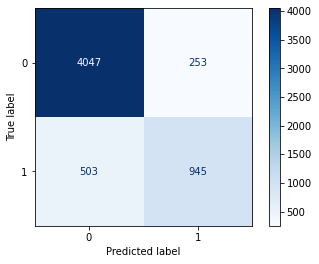

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix

cm_plot_labels = [x for x in range(2)]

cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=cm_plot_labels)

disp = disp.plot(include_values=True,
                 cmap=plt.cm.Blues, ax=None, xticks_rotation='horizontal')

plt.show()

In [100]:
print(confusion_matrix(y_val, y_pred))

[[4047  253]
 [ 503  945]]


# 5. Results

In [101]:
y_pred_test = vc.predict(test_df)

output = pd.DataFrame({'enrollee_id':test.enrollee_id.astype(np.int32), 'target':y_pred_test})
output.to_csv('my_submission.csv', index=False)